# Single catchment calibration

This notebook demonstrates how you might calibrate the model to a single gauging station.

In [17]:
import awrams.calibration.calibrate as cal
from awrams.calibration.sce import SCEOptimizer,ProxyOptimizer


from awrams.models import awral
from awrams.utils import datetools as dt

import pandas as pd

import os

# %matplotlib inline
from matplotlib import pyplot

data_path = '../../test_data/calibration/'

In [18]:
cal_catchment= '421103' # '204007' # '421103'
time_period = dt.dates('1990 - 1995')
time_period

DatetimeIndex(['1990-01-01', '1990-01-02', '1990-01-03', '1990-01-04',
               '1990-01-05', '1990-01-06', '1990-01-07', '1990-01-08',
               '1990-01-09', '1990-01-10', 
               ...
               '1995-12-22', '1995-12-23', '1995-12-24', '1995-12-25',
               '1995-12-26', '1995-12-27', '1995-12-28', '1995-12-29',
               '1995-12-30', '1995-12-31'],
              dtype='datetime64[ns]', length=2191, freq='D', tz=None)

In [19]:
from awrams.utils import catchments

# Get the catchment as a spatial extent we can use as the bounds of the simulation
try:
    db = catchments.CatchmentDB()
    spatial = db.get_by_id(cal_catchment)

except ImportError as e:
    print(e)
    # read catchment extent from a pickle
    import pickle
    pkl = os.path.join(data_path,'extent_421103.pkl')
    spatial = pickle.load(open(pkl,'rb'))

spatial.cell_count

9

In [20]:
# cal.set_model(model=awral)

In [21]:
def change_path_to_forcing(imap):
    from awrams.utils.nodegraph import nodes
    
    FORCING = {
        'tmin'  : ('temp_min*','temp_min_day'),
        'tmax'  : ('temp_max*','temp_max_day'),
        'precip': ('rain_day*','rain_day'),
        'solar' : ('solar*'   ,'solar_exposure_day')
    }
    for k,v in FORCING.items():
        imap.mapping[k+'_f'] = nodes.forcing_from_ncfiles(data_path,v[0],v[1],cache=True)

change_path_to_forcing(cal.input_map)

In [22]:
# Load the observed streamflow data
csv = os.path.join(data_path,'q_obs.csv')
qobs = pd.read_csv(csv,parse_dates=[0])
qobs = qobs.set_index(qobs.columns[0])
obs = qobs[cal_catchment]

In [23]:
# Find all the calibratable parameters in the mapping...
# We'll calibrate n all of them, but you could equally create a subset...

parameters = cal.get_parameter_df(cal.input_map.mapping)
parameters

,Max,Min,Value
Name,,,
w0ref_alb_hrudr,0.50,0.200,0.300000
k_rout_int,3.00,0.050,0.157715
gfrac_max_hrudr,0.50,0.250,0.300000
slope_coeff,1.00,0.010,0.951766
wslimu_hrudr,0.50,0.150,0.300000
w0ref_alb_hrusr,0.50,0.200,0.300000
er_frac_ref_hrudr,0.25,0.040,0.073556
fsoilemax_hrusr,1.00,0.200,0.929708
kssat_scale,10.00,0.010,0.020238


In [24]:
# create the model evaluator...
evaluator = cal.RunoffEvaluator(time_period,spatial,obs)

2016-10-13 03:46:39,860 INFO initialising model simulator...
2016-10-13 03:46:41,535 INFO done


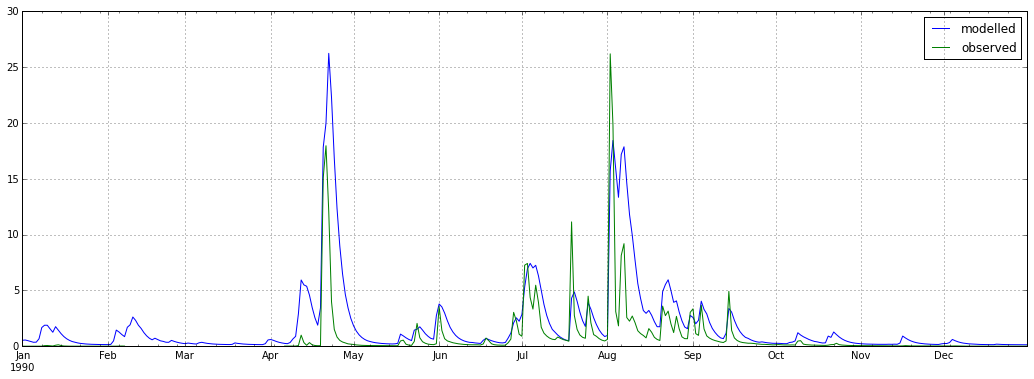

In [9]:
evaluator.plot(evaluator.initial_results,period=dt.dates('1990'))

In [25]:
# Create the SCE instance...
sce = ProxyOptimizer(13,5,4,3,3,parameters,evaluator)

In [26]:
# and run it...
sce.run_optimizer()

0 (65): 0.675405449458, 2.80879239063, 39.6206030649, (5.87s)
1 (127): 0.675405449458, 1.09896204762, 2.26035562048, (7.29s)
2 (184): 0.435434802368, 0.796493442973, 1.19862593087, (9.04s)
3 (228): 0.4012874829, 0.646348109575, 0.779390240563, (10.89s)
4 (253): 0.336956452147, 0.494926761248, 0.58397485984, (12.24s)
5 (267): 0.336956452147, 0.430472852947, 0.58397485984, (13.68s)
6 (281): 0.336956452147, 0.415399160322, 0.58397485984, (15.06s)
7 (296): 0.284722752641, 0.392799080293, 0.58397485984, (16.52s)
8 (311): 0.284722752641, 0.377621601368, 0.58397485984, (17.90s)
9 (327): 0.273745216824, 0.353763810697, 0.58397485984, (19.37s)
10 (343): 0.243423462857, 0.332984190005, 0.58397485984, (20.79s)
11 (358): 0.23821016709, 0.302703141931, 0.58397485984, (22.16s)
12 (372): 0.23495853664, 0.290981016324, 0.58397485984, (23.41s)
13 (388): 0.231945848925, 0.282628136966, 0.58397485984, (24.81s)
14 (401): 0.230231502576, 0.25371138717, 0.352454494134, (25.97s)
15 (418): 0.228560869042, 0.2

w0ref_alb_hrudr        0.333660
k_rout_int             2.000672
gfrac_max_hrudr        0.292566
slope_coeff            0.675835
wslimu_hrudr           0.276407
w0ref_alb_hrusr        0.335647
er_frac_ref_hrudr      0.215138
fsoilemax_hrusr        0.905898
kssat_scale            4.372713
alb_wet_hrudr          0.305210
gfrac_max_hrusr        0.327390
kdsat_scale            0.010875
wslimu_hrusr           0.187455
rd_hrusr               0.899952
lairef_hrusr           2.324806
k_rout_scale           1.735774
vc_hrudr               0.194635
cgsmax_hrusr           0.037621
wdlimu_hrudr           0.219229
tsenc_hrudr          159.386084
fvegref_g_hrudr        0.186799
pref_gridscale         1.688273
us0_hrusr              6.392388
sla_hrusr             35.820103
us0_hrudr              4.102683
w0lime_hrusr           0.774413
ne_scale               0.695546
s0max_scale            1.302970
ud0_hrudr              6.880982
rd_hrudr              10.162586
s_sls_hrusr            0.539352
ud0_hrus

In [12]:
sce.population.iloc[0]

vc_hrudr               0.162475
w0lime_hrudr           0.740661
s_sls_hrudr            0.688491
k_gw_scale             0.154179
kdsat_scale            0.010002
rd_hrusr               1.546677
k_rout_scale           2.335553
sdmax_scale            0.710207
alb_dry_hrudr          0.314181
ud0_hrudr              8.376374
wslimu_hrudr           0.387319
w0ref_alb_hrusr        0.433128
ud0_hrusr              4.998810
alb_wet_hrudr          0.131763
fvegref_g_hrusr        0.145330
lairef_hrudr           2.322301
us0_hrudr              3.977343
fvegref_g_hrudr        0.122918
k0sat_scale            6.256639
w0ref_alb_hrudr        0.381328
tgrow_hrudr          798.276125
tgrow_hrusr          298.868994
s0max_scale            0.583962
wdlimu_hrudr           0.303112
kssat_scale            7.479440
fsoilemax_hrusr        0.831111
ssmax_scale            0.933446
rd_hrudr              10.739094
gfrac_max_hrusr        0.354782
alb_wet_hrusr          0.156427
wdlimu_hrusr           0.273717
pref_gri

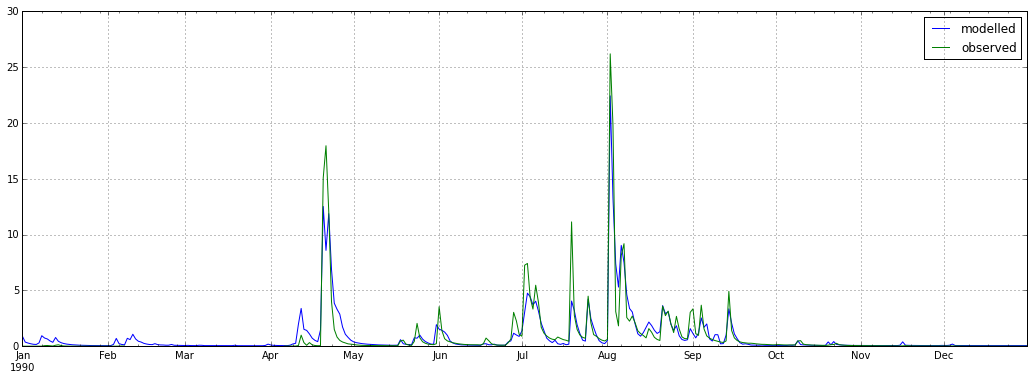

In [13]:
evaluator.plot(evaluator.run_sim(sce.population.iloc[0]),period=dt.dates('1990'))

In [27]:
# run with seed population...
sce.run_optimizer(seed=sce.population.iloc[0])

0 (13): 0.190796005194, 0.510331538662, 0.785299589547, (1.20s)
1 (29): 0.190796005194, 0.471090240504, 0.785299589547, (2.74s)
2 (44): 0.190796005194, 0.41818963928, 0.785299589547, (4.19s)
3 (60): 0.190796005194, 0.35943414563, 0.543302374547, (5.72s)
4 (72): 0.190796005194, 0.330653630916, 0.543302374547, (6.89s)
Maximum non-improving shuffle loops executed


w0ref_alb_hrudr        0.333660
k_rout_int             2.000672
gfrac_max_hrudr        0.292566
slope_coeff            0.675835
wslimu_hrudr           0.276407
w0ref_alb_hrusr        0.335647
er_frac_ref_hrudr      0.215138
fsoilemax_hrusr        0.905898
kssat_scale            4.372713
alb_wet_hrudr          0.305210
gfrac_max_hrusr        0.327390
kdsat_scale            0.010875
wslimu_hrusr           0.187455
rd_hrusr               0.899952
lairef_hrusr           2.324806
k_rout_scale           1.735774
vc_hrudr               0.194635
cgsmax_hrusr           0.037621
wdlimu_hrudr           0.219229
tsenc_hrudr          159.386084
fvegref_g_hrudr        0.186799
pref_gridscale         1.688273
us0_hrusr              6.392388
sla_hrusr             35.820103
us0_hrudr              4.102683
w0lime_hrusr           0.774413
ne_scale               0.695546
s0max_scale            1.302970
ud0_hrudr              6.880982
rd_hrudr              10.162586
s_sls_hrusr            0.539352
ud0_hrus

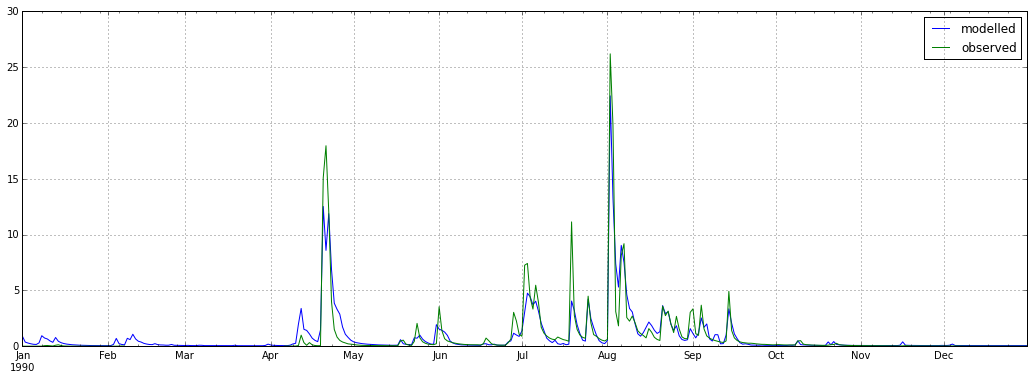

In [15]:
evaluator.plot(evaluator.run_sim(sce.population.iloc[0]),period=dt.dates('1990'))

In [16]:
# kill the sce workers...cleanup child processes
sce.terminate_children()